In [1]:
import json
import pandas
import numpy
import dotenv
import os

from matplotlib_venn import venn3
from matplotlib import pyplot as plt

from typing import List, Dict, Literal

In [2]:
env = dotenv.dotenv_values()

Part = Literal["sentence", "paragraph", "page"]
Language = Literal["en", "sk", "de"]
Model = Literal["e5", "labse", "gte"]
Id = str

PARTS: List[Part] = ["page", "paragraph", "sentence"]
LANGUAGES: List[Language] = ["en", "sk", "de"]
MODELS: List[Model] = ["e5", "labse", "gte"]
PG_TGRM = "tgrm"
CHAT_GPT = "gpt"

ALL_MODELS = [PG_TGRM, *MODELS]

DATA_DIR = "../../data"

SPACE = " "


MODEL_COMBINATIONS = []
ALL_RETRIEVAL_MODELS = [PG_TGRM, *MODELS]
for i in range(len(ALL_RETRIEVAL_MODELS)):
    for j in range(i + 1, len(ALL_RETRIEVAL_MODELS)):
        m1 = ALL_RETRIEVAL_MODELS[i]
        m2 = ALL_RETRIEVAL_MODELS[j]
        MODEL_COMBINATIONS.append((m1, m2))


with open(f"{DATA_DIR}/dataset/02_queries-EN.json", "r") as file:
    en_queries: List[str] = json.load(file)
with open(f"{DATA_DIR}/dataset/02_queries-SK.json", "r") as file:
    sk_queries: List[str] = json.load(file)
with open(f"{DATA_DIR}/dataset/02_queries-DE.json", "r") as file:
    de_queries: List[str] = json.load(file)

queries_by_language = {
    "en": en_queries,
    "sk": sk_queries,
    "de": de_queries
}

COEFFS = [0.05, 0.10, 0.25]

In [3]:
def set_attr(obj: dict, path: str, value, *, append: bool = False):
    keys = path.split(".")
    last_key = keys[-1]

    for key in keys[:-1]:
        if key not in obj:
            obj[key] = {}

        obj = obj[key]

    if last_key in obj:
        if append:
            obj[last_key].append(value)
        else:
            obj[last_key] = value
    else:
        if append:
            obj[last_key] = [value]
        else:
            obj[last_key] = value


def get_attr(obj: dict, path: str):
    keys = path.split(".")
    last_key = keys[-1]

    for key in keys[:-1]:
        if key not in obj:
            return None

        obj = obj[key]

    if last_key not in obj:
        return None

    return obj[last_key]


def plm():
    result = []

    for part in PARTS:
        for lang in LANGUAGES:
            for model in ALL_MODELS:
                result.append((part, lang, model))

    return result


def plmi():
    result = []

    for part, lang, model in plm():
        for idx in range(len(queries_by_language[lang])):
            result.append((part, lang, model, idx))

    return result


def get_id(part: Part, lang: Language, idx: int) -> Id:
    return f"{part}-{lang}-{idx + 1}"


def get_retrieval_path(model: Model, id: Id):
    return f"{DATA_DIR}/retrieval/{model}/{id}.json"


def normalize(maxx, minn, similarity):
    return (similarity - minn) / (maxx - minn)


def get_top_docs(docs, coeff: float):
    if len(docs) == 0:
        return []

    top_doc = docs[0]
    top_similarity = top_doc["similarity"]
    similarity_threshold = top_similarity * (1 - coeff)

    return list(filter(
        lambda doc: doc["similarity"] >= similarity_threshold,
        docs
    ))


def get_ordering_score(docs_1, docs_2):
    score = 0

    l1 = len(docs_1)
    l2 = len(docs_2)

    if min(l1, l2) == 0:
        return 0

    for i in range(min(l1, l2)):
        doc_1 = docs_1[i]
        doc_2 = docs_2[i]

        if doc_1["id"] == doc_2["id"]:
            score += 1 / (i + 1)

    n = sum([1 / (i + 1) for i in range(min(l1, l2))])

    match_score = score / n
    return match_score


def get_intersection_score(docs_1, docs_2):
    def get_doc_id(doc):
        return doc["id"]

    doc_ids_1 = list(map(get_doc_id, docs_1))
    doc_ids_2 = list(map(get_doc_id, docs_2))

    l1 = len(doc_ids_1)
    l2 = len(doc_ids_2)

    if min(l1, l2) == 0:
        return 0

    intersection = set(doc_ids_1).intersection(set(doc_ids_2))
    union = set(doc_ids_1).union(set(doc_ids_2))
    n = len(union)

    return len(intersection) / n


def to_csv(df, name):
    base_dir = f"{DATA_DIR}/results"
    os.makedirs(f"{base_dir}", exist_ok=True)
    df.to_csv(f"{base_dir}/{name}.csv")

In [4]:
with open(f"{DATA_DIR}/dataset/03_judgements.json", "r") as file:
    judgements_by_query: Dict[str, List[str]] = json.load(file)

JUDGEMENTS = []

for idx, query in enumerate(en_queries):
    relevant_document_ids = judgements_by_query[query]

    JUDGEMENTS.append({
        "model_id": CHAT_GPT,
        "query_id": idx + 1,
        "documents": list(map(
            lambda id: {"id": id},
            relevant_document_ids
        )),
    })

In [5]:
RETRIEVALS = {}

for part, lang, model, idx in plmi():
    RETRIEVALS[(
        part, lang, model, idx
    )] = json.load(open(get_retrieval_path(
        model, get_id(part, lang, idx)
    ), "r"))

In [6]:
def stats(retrievals, get_group_stats_path, group_iterator):
    results = {}

    for key, retrieval in retrievals.items():
        path = get_group_stats_path(key)

        similarities = list(map(
            lambda doc: doc["similarity"],
            retrieval["documents"]
        ))

        if len(similarities) == 0:
            continue

        set_attr(
            results,
            f"{path}.avg",
            numpy.average(similarities),
            append=True
        )

        set_attr(
            results,
            f"{path}.max",
            numpy.max(similarities),
            append=True
        )

        set_attr(
            results,
            f"{path}.min",
            numpy.min(similarities),
            append=True
        )

        set_attr(
            results,
            f"{path}.std",
            numpy.std(similarities),
            append=True
        )

    average = []
    total_maxs = []
    avg_maxs = []
    total_mins = []
    avg_mins = []
    avg_stds = []
    coeffs_from_total = []
    coeffs_from_avg = []

    for group in group_iterator:
        path = get_group_stats_path(group)

        avg_path = f"{path}.avg"
        max_path = f"{path}.max"
        min_path = f"{path}.min"
        std_path = f"{path}.std"

        avg_avg = numpy.max(get_attr(results, avg_path))
        total_max = numpy.max(get_attr(results, max_path))
        avg_max = numpy.average(get_attr(results, max_path))
        total_min = numpy.min(get_attr(results, min_path))
        avg_min = numpy.average(get_attr(results, min_path))
        avg_std = numpy.average(get_attr(results, std_path))
        coeff_from_total = avg_std / total_max
        coeff_from_avg = avg_std / avg_max

        average.append(avg_avg)
        total_maxs.append(total_max)
        avg_maxs.append(avg_max)
        total_mins.append(total_min)
        avg_mins.append(avg_min)
        avg_stds.append(avg_std)
        coeffs_from_total.append(coeff_from_total)
        coeffs_from_avg.append(coeff_from_avg)

    df = pandas.DataFrame({
        "average": average,
        "total_max": total_maxs,
        "avg_max": avg_maxs,
        "total_min": total_mins,
        "avg_min": avg_mins,
        "avg_std": avg_stds,
        "coeff_from_total": coeffs_from_total,
        "coeff_from_avg": coeffs_from_avg
    })

    df.index = pandas.MultiIndex.from_tuples(group_iterator)
    df.columns = pandas.MultiIndex.from_tuples([
        ("", "avg"),
        ("max", "total"), ("max", "average"),
        ("min", "total"), ("min", "average"),
        ("std", "average"),
        ("coeff", "from_total"), ("coeff", "from_average")
    ])

    return df

# Without merging by language

In [7]:
df_1 = stats(
    RETRIEVALS,
    lambda key: f"{key[0]}.{key[1]}.{key[2]}",
    plm()
)

to_csv(df_1, "stats")

df_1

max                 min            \
                         avg     total   average     total   average   
page      en tgrm   0.106532  0.838710  0.302822  0.003448  0.010793   
             e5     0.918190  0.988731  0.950456  0.830742  0.857204   
             labse  0.676937  0.969995  0.767191  0.448340  0.520494   
             gte    0.810895  0.983127  0.906754  0.625348  0.686875   
          sk tgrm   0.068630  0.592593  0.141298  0.003441  0.009854   
             e5     0.906789  0.982381  0.940184  0.831875  0.850546   
             labse  0.690159  0.951895  0.764757  0.465737  0.547602   
             gte    0.811391  0.960849  0.883686  0.658134  0.698387   
          de tgrm   0.099177  0.621622  0.180482  0.002967  0.010116   
             e5     0.909897  0.983006  0.945173  0.828883  0.850876   
             labse  0.694276  0.959093  0.770081  0.469226  0.546717   
             gte    0.796612  0.964170  0.887752  0.652175  0.692821   
paragraph en tgrm   0.272380  1.000000  0.516208  0.006098  0.030572   
             e5     0.940128  0.996055  0.970051  0.000000  0.197145   
             labse  0.720384  0.993652  0.846169  0.000000  0.309248   
             gte    0.843834  0.990857  0.919496  0.000000  0.328108   
          sk tgrm   0.130610  0.828571  0.268057  0.011111  0.025774   
             e5     0.933340  0.991958  0.959784  0.000000  0.355945   
             labse  0.736134  0.972680  0.837534  0.000000  0.400441   
             gte    0.852503  0.977300  0.903436  0.000000  0.387746   
          de tgrm   0.210203  0.785714  0.313692  0.006897  0.028651   
             e5     0.935851  0.993590  0.960118  0.000000  0.183805   
             labse  0.738324  0.960033  0.843662  0.000000  0.392088   
             gte    0.827719  0.977354  0.908332  0.000000  0.389760   
sentence  en tgrm   0.288702  1.000000  0.533859  0.006098  0.038067   
             e5     0.944028  0.996055  0.939505  0.000000  0.189538   
             labse  0.735698  0.993653  0.841984  0.000000  0.159438   
             gte    0.855625  0.990857  0.917925  0.000000  0.269345   
          sk tgrm   0.164375  0.941176  0.279033  0.018868  0.037815   
             e5     0.931648  0.991958  0.959864  0.000000  0.130641   
             labse  0.766381  0.972680  0.841317  0.000000  0.130278   
             gte    0.864830  0.977300  0.905577  0.000000  0.299089   
          de tgrm   0.235645  0.785714  0.331075  0.006897  0.034320   
             e5     0.938766  0.993590  0.960234  0.000000  0.160656   
             labse  0.771441  0.960033  0.846796  0.000000  0.169752   
             gte    0.837429  0.977354  0.910416  0.000000  0.331264   

                         std      coeff               
                     average from_total from_average  
page      en tgrm   0.029307   0.034943     0.096778  
             e5     0.012766   0.012912     0.013432  
             labse  0.030709   0.031659     0.040028  
             gte    0.026325   0.026776     0.029032  
          sk tgrm   0.015470   0.026105     0.109484  
             e5     0.013728   0.013974     0.014601  
             labse  0.027838   0.029245     0.036401  
             gte    0.024193   0.025178     0.027377  
          de tgrm   0.018421   0.029634     0.102066  
             e5     0.013456   0.013689     0.014237  
             labse  0.028407   0.029619     0.036889  
             gte    0.024606   0.025521     0.027717  
paragraph en tgrm   0.059500   0.059500     0.115264  
             e5     0.075511   0.075810     0.077842  
             labse  0.059178   0.059556     0.069936  
             gte    0.053838   0.054334     0.058551  
          sk tgrm   0.030570   0.036895     0.114042  
             e5     0.066007   0.066542     0.068772  
             labse  0.046961   0.048280     0.056070  
             gte    0.045455   0.046511     0.050313  
          de tgrm   0.036078   0.045918     0.115012  
             e5     0.084219   0.

In [8]:
normalized_retrievals = {}

for part, lang, model in plm():
    queries = queries_by_language[lang]
    retrievals = []

    for idx in range(len(queries)):
        retrieval = RETRIEVALS[(part, lang, model, idx)]
        retrievals.append(retrieval.copy())

    for retrieval in retrievals:
        retrieval["documents"] = list(filter(
            lambda doc: doc["similarity"] > 0,
            retrieval["documents"]
        ))

    max_similarity = None
    min_similarity = None

    for retrieval in retrievals:
        for doc in retrieval["documents"]:
            similarity = doc["similarity"]

            if max_similarity is None:
                max_similarity = similarity

            if min_similarity is None:
                min_similarity = similarity

            if similarity > max_similarity:
                max_similarity = similarity

            if similarity < min_similarity:
                min_similarity = similarity

    for retrieval in retrievals:
        normalized_retrievals[(
            retrieval["part"],
            retrieval["lang"],
            retrieval["model_id"] if "model_id" in retrieval else PG_TGRM,
            retrieval["query_id"] - 1
        )] = {
            **retrieval,
            "documents": list(map(
                lambda doc: {
                    **doc,
                    "similarity": normalize(
                        max_similarity,
                        min_similarity,
                        doc["similarity"]
                    )
                },
                retrieval["documents"])
            )
        }

In [9]:
df_2 = stats(
    normalized_retrievals,
    lambda key: f"{key[0]}.{key[1]}.{key[2]}",
    plm()
)

to_csv(df_2, "normalized_stats")

df_2

max             min                 std  \
                         avg total   average total   average   average   
page      en tgrm   0.123415   1.0  0.358419   0.0  0.008793  0.035087   
             e5     0.553509   1.0  0.757732   0.0  0.167493  0.080806   
             labse  0.438214   1.0  0.611230   0.0  0.138319  0.058868   
             gte    0.518608   1.0  0.786537   0.0  0.171969  0.073578   
          sk tgrm   0.110649   1.0  0.233991   0.0  0.010886  0.026258   
             e5     0.497748   1.0  0.719629   0.0  0.124056  0.091212   
             labse  0.461623   1.0  0.615067   0.0  0.168392  0.057262   
             gte    0.506275   1.0  0.745097   0.0  0.132971  0.079919   
          de tgrm   0.155515   1.0  0.286937   0.0  0.011555  0.029776   
             e5     0.525646   1.0  0.754528   0.0  0.142695  0.087309   
             labse  0.459410   1.0  0.614157   0.0  0.158188  0.057990   
             gte    0.462946   1.0  0.755067   0.0  0.130277  0.078867   
paragraph en tgrm   0.267916   1.0  0.513240   0.0  0.024624  0.059865   
             e5     0.551343   1.0  0.787855   0.0  0.208048  0.080850   
             labse  0.455094   1.0  0.710521   0.0  0.138169  0.082350   
             gte    0.532008   1.0  0.808398   0.0  0.155101  0.082801   
          sk tgrm   0.146183   1.0  0.314323   0.0  0.017937  0.037396   
             e5     0.479848   1.0  0.714494   0.0  0.174609  0.089495   
             labse  0.466278   1.0  0.695069   0.0  0.163408  0.077548   
             gte    0.574962   1.0  0.748432   0.0  0.166693  0.081275   
          de tgrm   0.261045   1.0  0.393925   0.0  0.027932  0.046324   
             e5     0.578455   1.0  0.707201   0.0  0.178220  0.081467   
             labse  0.481162   1.0  0.727672   0.0  0.166090  0.082867   
             gte    0.497874   1.0  0.767469   0.0  0.161675  0.082256   
sentence  en tgrm   0.284338   1.0  0.531000   0.0  0.032166  0.057526   
             e5     0.564843   1.0  0.763657   0.0  0.183922  0.086420   
             labse  0.523525   1.0  0.698817   0.0  0.153236  0.078541   
             gte    0.632598   1.0  0.815564   0.0  0.209394  0.080022   
          sk tgrm   0.157765   1.0  0.282080   0.0  0.020544  0.031519   
             e5     0.485753   1.0  0.712520   0.0  0.210547  0.086918   
             labse  0.516279   1.0  0.691985   0.0  0.214709  0.069335   
             gte    0.595392   1.0  0.736857   0.0  0.160845  0.083805   
          de tgrm   0.293713   1.0  0.416245   0.0  0.035211  0.046840   
             e5     0.582423   1.0  0.707738   0.0  0.202561  0.079433   
             labse  0.530037   1.0  0.717817   0.0  0.191497  0.076402   
             gte    0.505769   1.0  0.763565   0.0  0.172535  0.083464   

                        coeff               
                   from_total from_average  
page      en tgrm    0.035087     0.097893  
             e5      0.080806     0.106642  
             labse   0.058868     0.096311  
             gte     0.073578     0.093546  
          sk tgrm    0.026258     0.112217  
             e5      0.091212     0.126749  
             labse   0.057262     0.093098  
             gte     0.079919     0.107260  
          de tgrm    0.029776     0.103772  
             e5      0.087309     0.115714  
             labse   0.057990     0.094422  
             gte     0.078867     0.104451  
paragraph en tgrm    0.059865     0.116642  
             e5      0.080850     0.102620  
             labse   0.082350     0.115901  
             gte     0.082801     0.102425  
          sk tgrm    0.037396     0.118974  
             e5      0.089495     0.125256  
             labse   0.077548     0.111569  
             gte     0.081275     0.108594  
          de tgrm    0.046324     0.117597  
             e5      0.081467     0.115197  
             labse   0.082867     0.113880  
             gte     0.082256     0.107179  
sentence  en tgrm    0.057526     0.108335  
   

In [10]:
def get_retrieval(params, coeff):
    part, lang, model, idx = params

    if model == CHAT_GPT:
        retrieval = JUDGEMENTS[idx]
        top_docs = retrieval["documents"]
    else:
        retrieval = normalized_retrievals[(part, lang, model, idx)]
        top_docs = get_top_docs(retrieval["documents"], coeff)

    length = len(top_docs)

    return top_docs, length


values = {
    "part": [],
    "lang": [],
    "coeff": [],
    "model_1": [],
    "model_2": [],
    "count_1": [],
    "count_2": [],
    "ordering": [],
    "intersection": []
}

for part in PARTS:
    for lang in LANGUAGES:
        for coeff in COEFFS:
            queries = queries_by_language[lang]

            for model1, model2 in MODEL_COMBINATIONS:
                lengths_model1 = []
                lengths_model2 = []
                ordering_scores = []
                intersection_scores = []

                for idx, query in enumerate(queries):
                    docs_model1, l1 = get_retrieval(
                        (part, lang, model1, idx), coeff)

                    docs_model2, l2 = get_retrieval(
                        (part, lang, model2, idx), coeff)

                    lengths_model1.append(l1)
                    lengths_model2.append(l2)

                    ordering_scores.append(
                        get_ordering_score(docs_model1, docs_model2)
                    )

                    intersection_scores.append(
                        get_intersection_score(docs_model1, docs_model2)
                    )

                avg_length_model1 = numpy.average(lengths_model1)
                avg_length_model2 = numpy.average(lengths_model2)

                if len(ordering_scores):
                    avg_ordering_score = numpy.average(
                        ordering_scores
                    ).round(5)
                else:
                    avg_ordering_score = None

                avg_intersection_score = numpy.average(
                    intersection_scores
                ).round(5)

                values["part"].append(part)
                values["lang"].append(lang)
                values["coeff"].append(coeff)
                values["model_1"].append(model1)
                values["model_2"].append(model2)
                values["count_1"].append(avg_length_model1)
                values["count_2"].append(avg_length_model2)
                values["ordering"].append(avg_ordering_score)
                values["intersection"].append(avg_intersection_score)

df_3 = pandas.DataFrame({
    "model_1": values["model_1"],
    "model_2": values["model_2"],
    "count_1": values["count_1"],
    "count_2": values["count_2"],
    "ordering": values["ordering"],
    "intersection": values["intersection"]
})

df_3.index = pandas.MultiIndex.from_tuples([
    (PARTS[i], LANGUAGES[j], COEFFS[k])
    for i in range(len(PARTS))
    for j in range(len(LANGUAGES))
    for k in range(len(COEFFS))
    for _ in range(len(MODEL_COMBINATIONS))
])

to_csv(df_3, "model_model_comparison")

df_3

model_1 model_2  count_1  count_2  ordering  intersection
page     en 0.05    tgrm      e5    1.210    1.842   0.48733       0.46501
            0.05    tgrm   labse    1.210    1.744   0.46400       0.44802
            0.05    tgrm     gte    1.210    1.186   0.46333       0.46667
            0.05      e5   labse    1.842    1.744   0.52964       0.50599
            0.05      e5     gte    1.842    1.186   0.65303       0.61514
...                  ...     ...      ...      ...       ...           ...
sentence de 0.25    tgrm   labse    7.652   16.410   0.17966       0.15094
            0.25    tgrm     gte    7.652   14.350   0.18955       0.16438
            0.25      e5   labse   26.696   16.410   0.15997       0.16480
            0.25      e5     gte   26.696   14.350   0.18313       0.15205
            0.25   labse     gte   16.410   14.350   0.42875       0.28876

[162 rows x 6 columns]

In [11]:
values = {
    "part": [],
    "lang": [],
    "coeff": [],
    "model_1": [],
    "model_2": [],
    "count_1": [],
    "count_2": [],
    "intersection": []
}

for part in PARTS:
    for lang in LANGUAGES:
        for coeff in COEFFS:
            queries = queries_by_language[lang]

            for model in ALL_MODELS:
                lengths_gpt = []
                lengths_model = []
                intersection_scores = []

                for idx, query in enumerate(queries):
                    docs_gpt, l_gpt = get_retrieval(
                        (part, lang, CHAT_GPT, idx), coeff)

                    docs_model, l_model = get_retrieval(
                        (part, lang, model, idx), coeff)

                    lengths_gpt.append(l_gpt)
                    lengths_model.append(l_model)

                    intersection_scores.append(
                        get_intersection_score(docs_gpt, docs_model)
                    )

                avg_length_gpt = numpy.average(lengths_gpt)
                avg_length_model = numpy.average(lengths_model)

                if len(ordering_scores):
                    avg_ordering_score = numpy.average(
                        ordering_scores
                    ).round(5)
                else:
                    avg_ordering_score = None

                avg_intersection_score = numpy.average(
                    intersection_scores
                ).round(5)

                values["part"].append(part)
                values["lang"].append(lang)
                values["coeff"].append(coeff)
                values["model_1"].append(CHAT_GPT)
                values["model_2"].append(model)
                values["count_1"].append(avg_length_gpt)
                values["count_2"].append(avg_length_model)
                values["intersection"].append(avg_intersection_score)

df_4 = pandas.DataFrame({
    "model_1": values["model_1"],
    "model_2": values["model_2"],
    "count_1": values["count_1"],
    "count_2": values["count_2"],
    "intersection": values["intersection"]
})

df_4.index = pandas.MultiIndex.from_tuples([
    (PARTS[i], LANGUAGES[j], COEFFS[k])
    for i in range(len(PARTS))
    for j in range(len(LANGUAGES))
    for k in range(len(COEFFS))
    for _ in range(len(ALL_MODELS))
])

to_csv(df_4, "model_dataset_comparison")

df_4.head(10)

model_1 model_2  count_1  count_2  intersection
page en 0.05     gpt    tgrm     4.53    1.210       0.28970
        0.05     gpt      e5     4.53    1.842       0.43197
        0.05     gpt   labse     4.53    1.744       0.36122
        0.05     gpt     gte     4.53    1.186       0.57678
        0.10     gpt    tgrm     4.53    1.458       0.29675
        0.10     gpt      e5     4.53    3.746       0.39564
        0.10     gpt   labse     4.53    2.976       0.35118
        0.10     gpt     gte     4.53    1.510       0.57507
        0.25     gpt    tgrm     4.53    3.156       0.29239
        0.25     gpt      e5     4.53   38.122       0.15288

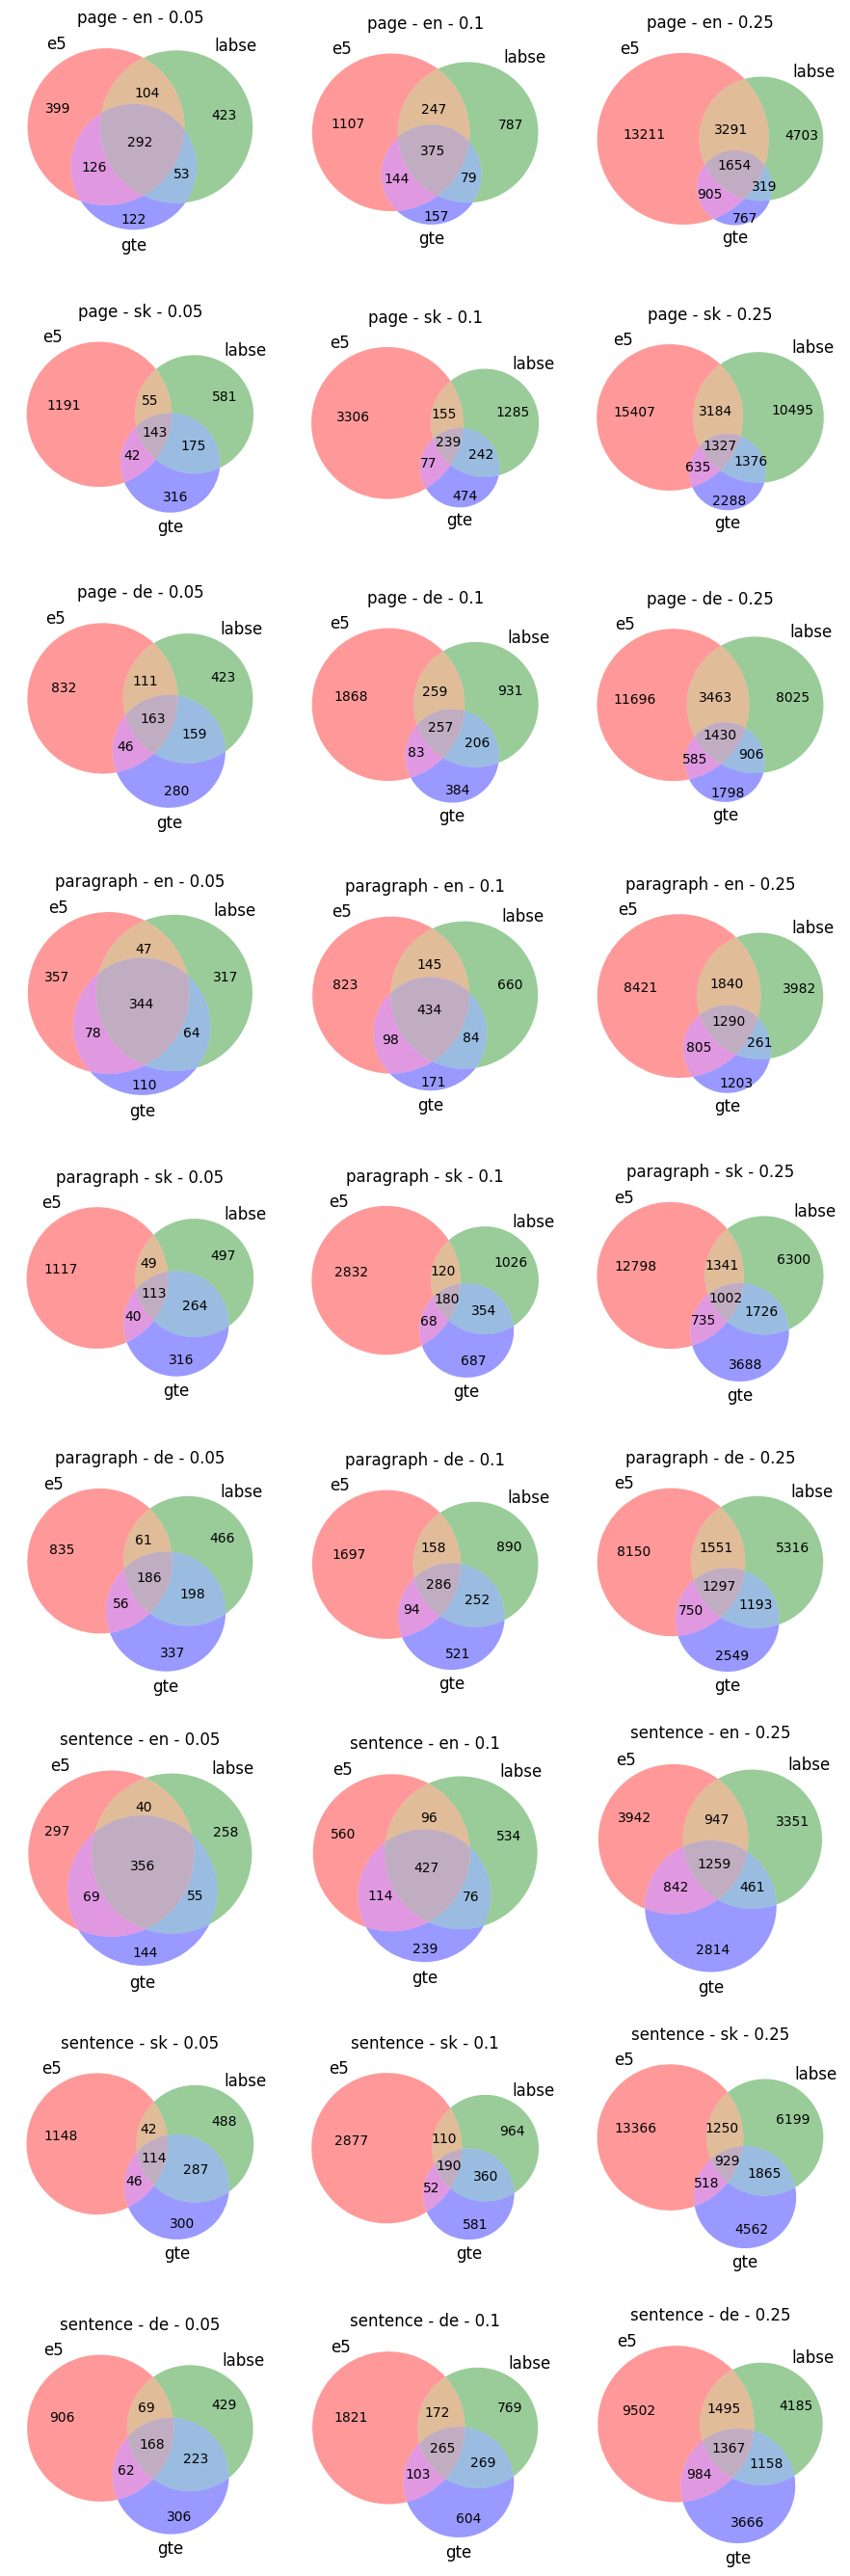

In [12]:
plots = []

for part in PARTS:
    for lang in LANGUAGES:
        for coeff in COEFFS:
            sets = []
            queries = queries_by_language[lang]

            for model in MODELS:
                total_docs = set()

                for idx, query in enumerate(queries):
                    docs, length = get_retrieval(
                        (part, lang, model, idx), coeff)

                    for doc in docs:
                        total_docs.add(f"{doc["id"]}-{idx}")

                sets.append(total_docs)

            plots.append({
                "sets": sets,
                "title": f"{part} - {lang} - {coeff}"
            })


n_plots = len(plots)
n_cols = 3
n_rows = (n_plots + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows))

if n_rows == 1:
    axes = axes.reshape(-1)
else:
    axes = axes.flatten()

for i, plot_data in enumerate(plots):
    venn3(plot_data["sets"], MODELS, ax=axes[i])
    axes[i].set_title(plot_data["title"])

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

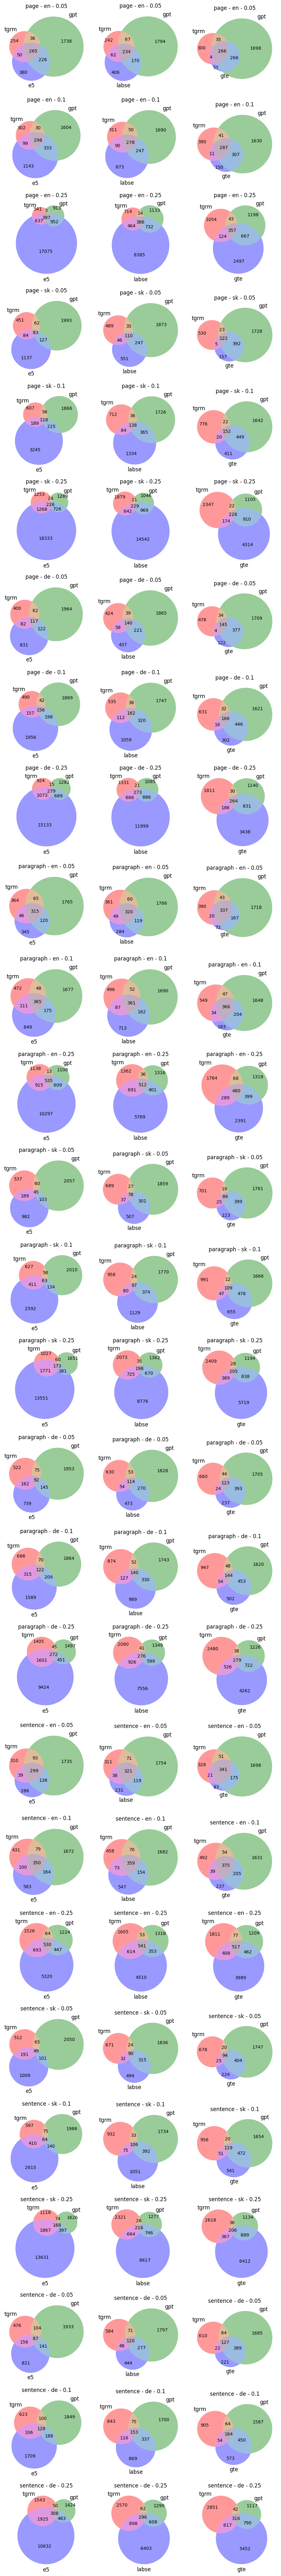

In [13]:
plots = []

for part in PARTS:
    for lang in LANGUAGES:
        for coeff in COEFFS:
            queries = queries_by_language[lang]

            for model in MODELS:
                sets = []
                docs_tgrm_total = set()
                docs_gpt_total = set()
                docs_model_total = set()

                for idx, query in enumerate(queries):
                    docs_tgrm, _ = get_retrieval(
                        (part, lang, PG_TGRM, idx), coeff)

                    docs_gpt, _ = get_retrieval(
                        (part, lang, CHAT_GPT, idx), coeff)

                    docs_model, _ = get_retrieval(
                        (part, lang, model, idx), coeff)

                    for doc in docs_tgrm:
                        docs_tgrm_total.add(f"{doc["id"]}-{idx}")

                    for doc in docs_gpt:
                        docs_gpt_total.add(f"{doc["id"]}-{idx}")

                    for doc in docs_model:
                        docs_model_total.add(f"{doc["id"]}-{idx}")

                sets.append(docs_tgrm_total)
                sets.append(docs_gpt_total)
                sets.append(docs_model_total)

                plots.append({
                    "sets": sets,
                    "labels": [PG_TGRM, CHAT_GPT, model],
                    "title": f"{part} - {lang} - {coeff}"
                })

n_plots = len(plots)
n_cols = 3
n_rows = (n_plots + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows))

if n_rows == 1:
    axes = axes.reshape(-1)
else:
    axes = axes.flatten()

for i, plot_data in enumerate(plots):
    venn3(plot_data["sets"], plot_data["labels"], ax=axes[i])
    axes[i].set_title(plot_data["title"])

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

# With merging by language

In [14]:
merged_retrievals = {}

for part in PARTS:
    for model in ALL_MODELS:
        for idx in range(len(queries_by_language["en"])):
            documents = []

            for lang in LANGUAGES:
                retrieval = RETRIEVALS[(part, lang, model, idx)]                
                documents.extend(retrieval["documents"].copy())

            # Sort by similarity, descending
            documents.sort(key=lambda doc: doc["similarity"], reverse=True)

            # Remove duplicates
            duplicate_ids = set()

            def is_duplicate(doc):
                if doc["id"] in duplicate_ids:
                    return True

                duplicate_ids.add(doc["id"])
                return False

            documents = list(filter(
                lambda doc: not is_duplicate(doc),
                documents
            ))

            merged_retrievals[(part, model, idx)] = {
                "part": part,
                "model_id": model,
                "query_id": idx + 1,
                "documents": documents
            }

In [15]:
df_5 = stats(
    merged_retrievals,
    lambda key: f"{key[0]}.{key[1]}",
    [(part, model) for part in PARTS for model in ALL_MODELS]
)

to_csv(df_5, "merged_stats")

df_5

max                 min                 std  \
                      avg     total   average     total   average   average   
page      tgrm   0.108411  0.838710  0.311394  0.006147  0.012706  0.029076   
          e5     0.921910  0.988731  0.954471  0.848138  0.865144  0.012949   
          labse  0.694903  0.969995  0.783225  0.492377  0.555844  0.028371   
          gte    0.813864  0.983127  0.909428  0.659103  0.704108  0.024892   
paragraph tgrm   0.275490  1.000000  0.527923  0.020833  0.043162  0.059096   
          e5     0.942810  0.996055  0.972647  0.000000  0.729370  0.019244   
          labse  0.745886  0.993652  0.862686  0.000000  0.545362  0.038425   
          gte    0.854049  0.990857  0.933446  0.000000  0.589032  0.031176   
sentence  tgrm   0.290764  1.000000  0.540548  0.024242  0.053092  0.056295   
          e5     0.946311  0.996055  0.972508  0.000000  0.519587  0.031917   
          labse  0.772789  0.993653  0.865227  0.000000  0.340466  0.044795   
          gte    0.868614  0.990857  0.935565  0.000000  0.550545  0.035315   

                     coeff               
                from_total from_average  
page      tgrm    0.034668     0.093375  
          e5      0.013096     0.013566  
          labse   0.029249     0.036224  
          gte     0.025319     0.027371  
paragraph tgrm    0.059096     0.111941  
          e5      0.019320     0.019785  
          labse   0.038671     0.044541  
          gte     0.031463     0.033399  
sentence  tgrm    0.056295     0.104145  
          e5      0.032043     0.032819  
          labse   0.045081     0.051773  
          gte     0.035641     0.037747

In [16]:
merged_normalized_retrievals = {}
merged_normalization_params = {}

for part in PARTS:
    for model in ALL_MODELS:
        tmp_retrievals = []

        max_similarity = None
        min_similarity = None

        for idx in range(len(queries_by_language["en"])):
            retrieval = merged_retrievals[(part, model, idx)]

            tmp_retrievals.append({
                **retrieval,
                "documents": list(filter(
                    lambda doc: doc["similarity"] > 0,
                    retrieval["documents"]
                ))
            })

        for retrieval in tmp_retrievals:
            for doc in retrieval["documents"]:
                similarity = doc["similarity"]

                if max_similarity is None:
                    max_similarity = similarity

                if min_similarity is None:
                    min_similarity = similarity

                if similarity > max_similarity:
                    max_similarity = similarity

                if similarity < min_similarity:
                    min_similarity = similarity

        merged_normalization_params[(part, model)] = (
            max_similarity,
            min_similarity
        )

        for retrieval in tmp_retrievals:
            merged_normalized_retrievals[(
                part, model, retrieval["query_id"] - 1
            )] = {
                **retrieval,
                "documents": list(map(
                    lambda doc: {
                        **doc,
                        "similarity": normalize(
                            max_similarity,
                            min_similarity,
                            doc["similarity"]
                        )
                    },
                    retrieval["documents"]
                ))
            }

In [17]:
df_6 = stats(
    merged_normalized_retrievals,
    lambda key: f"{key[0]}.{key[1]}",
    [(part, model) for part in PARTS for model in ALL_MODELS]
)

to_csv(df_6, "merged_normalized_stats")

df_6

max             min                 std  \
                      avg total   average total   average   average   
page      tgrm   0.122831   1.0  0.366636   0.0  0.007879  0.034924   
          e5     0.524716   1.0  0.756316   0.0  0.120957  0.092101   
          labse  0.424033   1.0  0.608955   0.0  0.132882  0.059402   
          gte    0.477621   1.0  0.772553   0.0  0.138893  0.076822   
paragraph tgrm   0.260074   1.0  0.517879   0.0  0.022803  0.060354   
          e5     0.585043   1.0  0.799554   0.0  0.188035  0.090005   
          labse  0.490092   1.0  0.730469   0.0  0.194362  0.074566   
          gte    0.546133   1.0  0.809538   0.0  0.138055  0.083493   
sentence  tgrm   0.273144   1.0  0.529133   0.0  0.029567  0.057694   
          e5     0.589744   1.0  0.798041   0.0  0.207331  0.086916   
          labse  0.512328   1.0  0.716431   0.0  0.178566  0.069863   
          gte    0.587879   1.0  0.813592   0.0  0.165735  0.082386   

                     coeff               
                from_total from_average  
page      tgrm    0.034924     0.095256  
          e5      0.092101     0.121776  
          labse   0.059402     0.097547  
          gte     0.076822     0.099439  
paragraph tgrm    0.060354     0.116540  
          e5      0.090005     0.112569  
          labse   0.074566     0.102079  
          gte     0.083493     0.103137  
sentence  tgrm    0.057694     0.109035  
          e5      0.086916     0.108912  
          labse   0.069863     0.097515  
          gte     0.082386     0.101262

In [18]:
def get_retrieval(params, coeff):
    part, model, idx = params

    if model == CHAT_GPT:
        retrieval = JUDGEMENTS[idx]
        top_docs = retrieval["documents"]
    else:
        retrieval = merged_normalized_retrievals[(part, model, idx)]
        top_docs = get_top_docs(retrieval["documents"], coeff)

    length = len(top_docs)

    return top_docs, length


values = {
    "part": [],
    "coeff": [],
    "model_1": [],
    "model_2": [],
    "count_1": [],
    "count_2": [],
    "ordering": [],
    "intersection": []
}

for part in PARTS:
    for coeff in COEFFS:
        queries = queries_by_language[lang]

        for model1, model2 in MODEL_COMBINATIONS:
            lengths_model1 = []
            lengths_model2 = []
            ordering_scores = []
            intersection_scores = []

            for idx, query in enumerate(queries):
                docs_model1, l1 = get_retrieval(
                    (part, model1, idx), coeff)

                docs_model2, l2 = get_retrieval(
                    (part, model2, idx), coeff)

                lengths_model1.append(l1)
                lengths_model2.append(l2)

                ordering_scores.append(
                    get_ordering_score(docs_model1, docs_model2)
                )

                intersection_scores.append(
                    get_intersection_score(docs_model1, docs_model2)
                )

            avg_length_model1 = numpy.average(lengths_model1)
            avg_length_model2 = numpy.average(lengths_model2)

            if len(ordering_scores):
                avg_ordering_score = numpy.average(
                    ordering_scores
                ).round(5)
            else:
                avg_ordering_score = None

            avg_intersection_score = numpy.average(
                intersection_scores
            ).round(5)

            values["part"].append(part)
            values["coeff"].append(coeff)
            values["model_1"].append(model1)
            values["model_2"].append(model2)
            values["count_1"].append(avg_length_model1)
            values["count_2"].append(avg_length_model2)
            values["ordering"].append(avg_ordering_score)
            values["intersection"].append(avg_intersection_score)

df_7 = pandas.DataFrame({
    "model_1": values["model_1"],
    "model_2": values["model_2"],
    "count_1": values["count_1"],
    "count_2": values["count_2"],
    "ordering": values["ordering"],
    "intersection": values["intersection"]
})

df_7.index = pandas.MultiIndex.from_tuples([
    (PARTS[i], COEFFS[j])
    for i in range(len(PARTS))
    for j in range(len(COEFFS))
    for _ in range(len(MODEL_COMBINATIONS))
])

to_csv(df_7, "merged_model_model_comparison")

df_7

model_1 model_2  count_1  count_2  ordering  intersection
page      0.05    tgrm      e5    1.234    1.884   0.39133       0.38393
          0.05    tgrm   labse    1.234    1.608   0.42667       0.42977
          0.05    tgrm     gte    1.234    1.190   0.49200       0.48097
          0.05      e5   labse    1.884    1.608   0.48673       0.46954
          0.05      e5     gte    1.884    1.190   0.53255       0.49511
          0.05   labse     gte    1.608    1.190   0.46576       0.47212
          0.10    tgrm      e5    1.514    3.954   0.38519       0.34828
          0.10    tgrm   labse    1.514    3.128   0.42352       0.39379
          0.10    tgrm     gte    1.514    1.478   0.49400       0.46255
          0.10      e5   labse    3.954    3.128   0.45935       0.41686
          0.10      e5     gte    3.954    1.478   0.52904       0.43231
          0.10   labse     gte    3.128    1.478   0.45878       0.41685
          0.25    tgrm      e5    3.088   30.268   0.35315       0.15184
          0.25    tgrm   labse    3.088   22.184   0.38722       0.24054
          0.25    tgrm     gte    3.088    5.580   0.45041       0.29678
          0.25      e5   labse   30.268   22.184   0.32873       0.25510
          0.25      e5     gte   30.268    5.580   0.42221       0.18380
          0.25   labse     gte   22.184    5.580   0.39034       0.25969
paragraph 0.05    tgrm      e5    1.494    1.826   0.53206       0.51427
          0.05    tgrm   labse    1.494    1.804   0.58581       0.56087
          0.05    tgrm     gte    1.494    1.268   0.63533       0.63978
          0.05      e5   labse    1.826    1.804   0.58479       0.55935
          0.05      e5     gte    1.826    1.268   0.67648       0.64552
          0.05   labse     gte    1.804    1.268   0.66477       0.62510
          0.10    tgrm      e5    1.912    3.744   0.52446       0.45264
          0.10    tgrm   labse    1.912    3.316   0.57917       0.51285
          0.10    tgrm     gte    1.912    1.902   0.63260       0.60391
          0.10      e5   labse    3.744    3.316   0.56493       0.49472
          0.10      e5     gte    3.744    1.902   0.65923       0.54782
          0.10   labse     gte    3.316    1.902   0.65587       0.55550
          0.25    tgrm      e5    4.872   29.078   0.46469       0.17921
          0.25    tgrm   labse    4.872   22.356   0.51944       0.24554
          0.25    tgrm     gte    4.872    6.836   0.58536       0.39624
          0.25      e5   labse   29.078   22.356   0.35609       0.25800
          0.25      e5     gte   29.078    6.836   0.53682       0.22492
          0.25   labse     gte   22.356    6.836   0.52773       0.27942
sentence  0.05    tgrm      e5    1.486    1.882   0.49752       0.49510
          0.05    tgrm   labse    1.486    1.714   0.55175       0.53385
          0.05    tgrm     gte    1.486    1.206   0.61200       0.62335
          0.05      e5   labse    1.882    1.714   0.56853       0.55072
          0.05      e5     gte    1.882    1.206   0.68023       0.64752
          0.05   labse     gte    1.714    1.206   0.66170       0.62698
          0.10    tgrm      e5    1.896    3.866   0.49033       0.44171
          0.10    tgrm   labse    1.896    2.996   0.54917       0.51302
          0.10    tgrm     gte    1.896    1.692   0.60707       0.58989
          0.10      e5   labse    3.866    2.996   0.55221       0.49244
          0.10      e5     gte    3.866    1.692   0.66734       0.53899
          0.10   labse     gte    2.996    1.692   0.65332       0.57444
          0.25    tgrm      e5    5.104   31.082   0.42138       0.16822
          0.25    tgrm   labse    5.104   19.108   0.48355       0.26509
          0.25    tgrm     gte    5.104    9.950   0.55259       0.36562
          0.25      e5   labse   31.082   19.108   0.35855       0.24579
          0.25      e5     gte   31.082    9.950   0.51078       0.21338
          0.25   labse     gte   19.108    9.950   0.52016       0.30312

In [19]:
values = {
    "part": [],
    "coeff": [],
    "model_1": [],
    "model_2": [],
    "count_1": [],
    "count_2": [],
    "intersection": []
}

for part in PARTS:
    for coeff in COEFFS:
        queries = queries_by_language[lang]

        for model in ALL_MODELS:
            lengths_gpt = []
            lengths_model = []
            intersection_scores = []

            for idx, query in enumerate(queries):
                docs_gpt, l_gpt = get_retrieval(
                    (part, CHAT_GPT, idx), coeff)

                docs_model, l_model = get_retrieval(
                    (part, model, idx), coeff)

                lengths_gpt.append(l_gpt)
                lengths_model.append(l_model)

                intersection_scores.append(
                    get_intersection_score(docs_gpt, docs_model)
                )

            avg_length_gpt = numpy.average(lengths_gpt)
            avg_length_model = numpy.average(lengths_model)

            if len(ordering_scores):
                avg_ordering_score = numpy.average(
                    ordering_scores
                ).round(5)
            else:
                avg_ordering_score = None

            avg_intersection_score = numpy.average(
                intersection_scores
            ).round(5)

            values["part"].append(part)
            values["coeff"].append(coeff)
            values["model_1"].append(CHAT_GPT)
            values["model_2"].append(model)
            values["count_1"].append(avg_length_gpt)
            values["count_2"].append(avg_length_model)
            values["intersection"].append(avg_intersection_score)

df_8 = pandas.DataFrame({
    "model_1": values["model_1"],
    "model_2": values["model_2"],
    "count_1": values["count_1"],
    "count_2": values["count_2"],
    "intersection": values["intersection"]
})

df_8.index = pandas.MultiIndex.from_tuples([
    (PARTS[i], COEFFS[j])
    for i in range(len(PARTS))
    for j in range(len(COEFFS))
    for _ in range(len(ALL_MODELS))
])

to_csv(df_8, "merged_model_dataset_comparison")

df_8

model_1 model_2  count_1  count_2  intersection
page      0.05     gpt    tgrm     4.53    1.234       0.29809
          0.05     gpt      e5     4.53    1.884       0.37134
          0.05     gpt   labse     4.53    1.608       0.33135
          0.05     gpt     gte     4.53    1.190       0.57855
          0.10     gpt    tgrm     4.53    1.514       0.30539
          0.10     gpt      e5     4.53    3.954       0.34223
          0.10     gpt   labse     4.53    3.128       0.30317
          0.10     gpt     gte     4.53    1.478       0.57031
          0.25     gpt    tgrm     4.53    3.088       0.29977
          0.25     gpt      e5     4.53   30.268       0.14659
          0.25     gpt   labse     4.53   22.184       0.20624
          0.25     gpt     gte     4.53    5.580       0.43815
paragraph 0.05     gpt    tgrm     4.53    1.494       0.41769
          0.05     gpt      e5     4.53    1.826       0.43042
          0.05     gpt   labse     4.53    1.804       0.40287
          0.05     gpt     gte     4.53    1.268       0.56350
          0.10     gpt    tgrm     4.53    1.912       0.41481
          0.10     gpt      e5     4.53    3.744       0.38571
          0.10     gpt   labse     4.53    3.316       0.37267
          0.10     gpt     gte     4.53    1.902       0.55659
          0.25     gpt    tgrm     4.53    4.872       0.36049
          0.25     gpt      e5     4.53   29.078       0.16587
          0.25     gpt   labse     4.53   22.356       0.19732
          0.25     gpt     gte     4.53    6.836       0.42259
sentence  0.05     gpt    tgrm     4.53    1.486       0.42205
          0.05     gpt      e5     4.53    1.882       0.43458
          0.05     gpt   labse     4.53    1.714       0.41013
          0.05     gpt     gte     4.53    1.206       0.56206
          0.10     gpt    tgrm     4.53    1.896       0.42089
          0.10     gpt      e5     4.53    3.866       0.39195
          0.10     gpt   labse     4.53    2.996       0.39013
          0.10     gpt     gte     4.53    1.692       0.55014
          0.25     gpt    tgrm     4.53    5.104       0.36179
          0.25     gpt      e5     4.53   31.082       0.15725
          0.25     gpt   labse     4.53   19.108       0.22557
          0.25     gpt     gte     4.53    9.950       0.39528

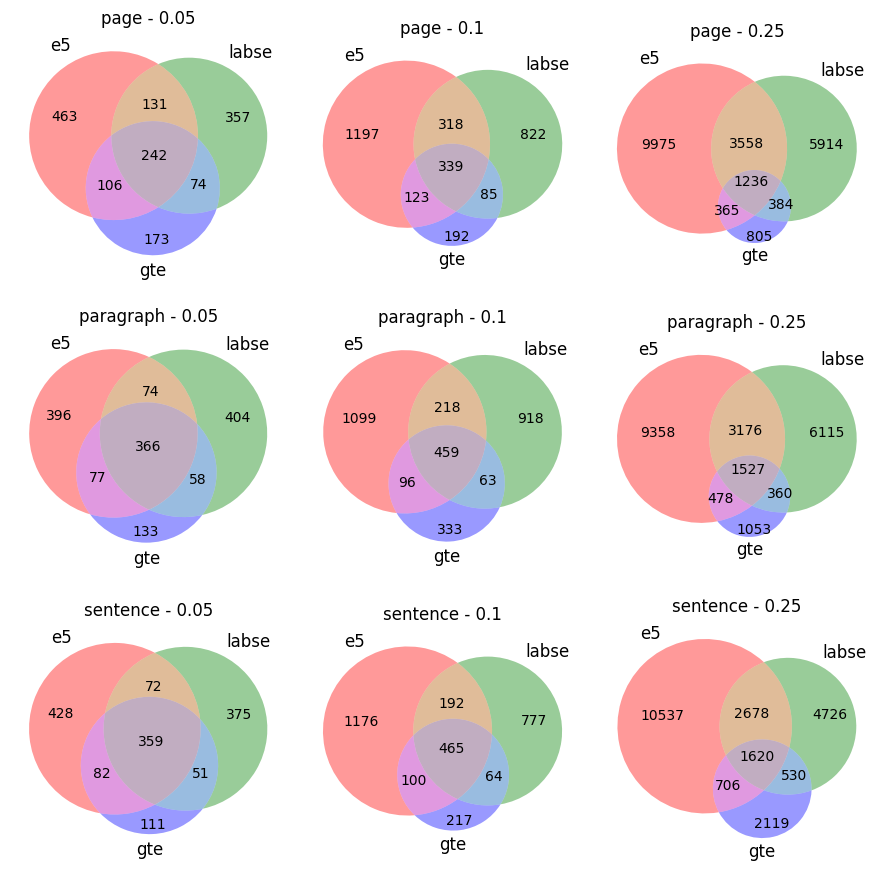

In [20]:
# def get_retrieval(params, coeff):
#     part, model, idx = params

#     retrieval = merged_normalized_retrievals[(part, model, idx)]
#     top_docs = get_top_docs(retrieval["documents"], coeff)
#     length = len(top_docs)

#     return top_docs, length

plots = []

for part in PARTS:
    for coeff in COEFFS:
        sets = []
        queries = queries_by_language[lang]

        for model in MODELS:
            total_docs = set()

            for idx, query in enumerate(queries):
                docs, length = get_retrieval(
                    (part, model, idx), coeff)

                for doc in docs:
                    total_docs.add(f"{doc["id"]}-{idx}")
            
            sets.append(total_docs)

        plots.append({
            "sets": sets,
            "title": f"{part} - {coeff}"
        })

n_plots = len(plots)
n_cols = 3
n_rows = (n_plots + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows))

if n_rows == 1:
    axes = axes.reshape(-1)
else:
    axes = axes.flatten()

for i, plot_data in enumerate(plots):
    venn3(plot_data["sets"], MODELS, ax=axes[i])
    axes[i].set_title(plot_data["title"])

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

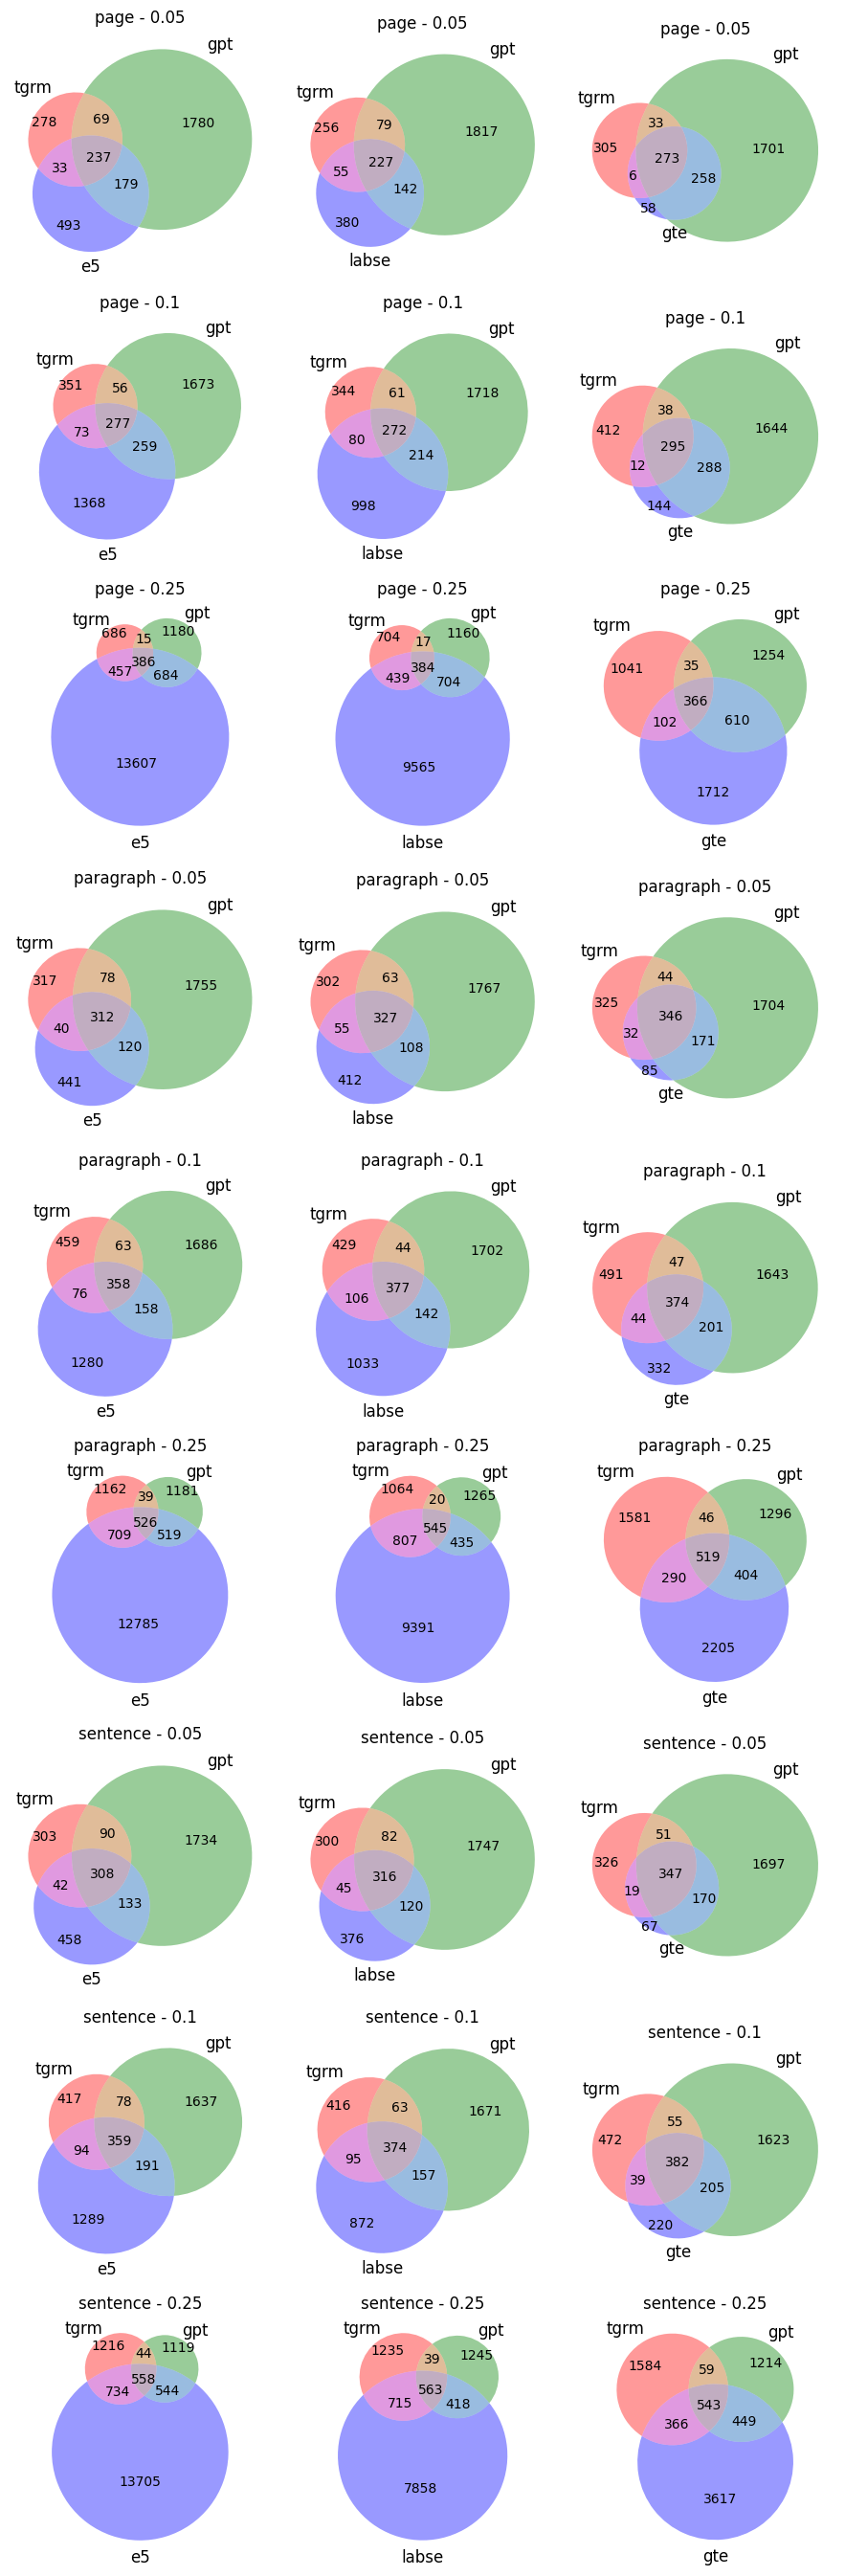

In [21]:
plots = []

for part in PARTS:
    for coeff in COEFFS:
        queries = queries_by_language[lang]

        for model in MODELS:
            sets = []
            docs_tgrm_total = set()
            docs_gpt_total = set()
            docs_model_total = set()

            for idx, query in enumerate(queries):
                docs_tgrm, _ = get_retrieval(
                    (part, PG_TGRM, idx), coeff)

                docs_gpt, _ = get_retrieval(
                    (part, CHAT_GPT, idx), coeff)

                docs_model, _ = get_retrieval(
                    (part, model, idx), coeff)

                for doc in docs_tgrm:
                    docs_tgrm_total.add(f"{doc["id"]}-{idx}")

                for doc in docs_gpt:
                    docs_gpt_total.add(f"{doc["id"]}-{idx}")

                for doc in docs_model:
                    docs_model_total.add(f"{doc["id"]}-{idx}")

            sets.append(docs_tgrm_total)
            sets.append(docs_gpt_total)
            sets.append(docs_model_total)

            plots.append({
                "sets": sets,
                "labels": [PG_TGRM, CHAT_GPT, model],
                "title": f"{part} - {coeff}"
            })

n_plots = len(plots)
n_cols = 3
n_rows = (n_plots + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows))

if n_rows == 1:
    axes = axes.reshape(-1)
else:
    axes = axes.flatten()

for i, plot_data in enumerate(plots):
    venn3(plot_data["sets"], plot_data["labels"], ax=axes[i])
    axes[i].set_title(plot_data["title"])

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()